# NN Model

In [57]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import plot_model

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline

data_path = '../data/'

### Loading Data

In [58]:
Submission = pd.read_csv(data_path+'01_raw/Submission.csv', delimiter='|')
AvailablePokemons = pd.read_csv(data_path+'01_raw/AvailablePokemons.csv', delimiter='|')
BattleResults = pd.read_csv(data_path+'01_raw/Battle_Results.csv', delimiter='|')
Weakness_Pokemon = pd.read_csv(data_path+'01_raw/Weakness_Pokemon.csv', delimiter='|')
AllPokemons = pd.read_csv(data_path+'01_raw/All_Pokemons.csv', delimiter='|')

### Data Pipeline Auxilliary Functions

In [60]:
def RelativeResult(X):
    HP = X.apply(lambda row: row["HP_1"] if row["BattleResult"] > 0 else row["HP_2"], axis=1).values
    relativized = X["BattleResult"].values / HP
    return relativized

In [61]:
class LevelScaler(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X / 99

In [62]:
class AddPokemonTypes(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.type_attributes = ['Type1_1', 'Type2_1', 'Type1_2', 'Type2_2'] # Where Type2_1 is the second type of the first pokemon
        self.NametoIndex = {sys.intern(name): AllPokemons.loc[AllPokemons["Name"]==name].iloc[0].ID-1 for name in AllPokemons.Name}
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df):
        # Values for faster processing
        df = df.copy()
        values = df.values
        AllPokemonTypes = AllPokemons.loc[:,['Type_1', 'Type_2']]
        AllPokemonTypes.Type_2 = AllPokemons.Type_2.fillna(AllPokemons.Type_1)
        AllPokemonTypes = AllPokemonTypes.values
        
        # Old Column indexes
        name1_idx = df.columns.get_loc("Name_1")
        name2_idx = df.columns.get_loc("Name_2")

        # New Columns
        Types = np.empty((len(df),4), dtype='U15')

        for i in range(len(df)):
            idx_1 = self.NametoIndex[values[i,name1_idx]]
            idx_2 = self.NametoIndex[values[i,name2_idx]]

            # Types
            Types[i, 0] = AllPokemonTypes[idx_1, 0]
            Types[i, 1] = AllPokemonTypes[idx_1, 1]
            Types[i, 2] = AllPokemonTypes[idx_2, 0]
            Types[i, 3] = AllPokemonTypes[idx_2, 1]

        
        # Add columns
        df[self.type_attributes] = pd.DataFrame(Types, index=df.index)
        return df

In [63]:
def DuplicateData(df, y):
    df_inverse = df.copy()
    y_inverse = y.copy()
    
    # Inverse y
    y_inverse = (-1) * y_inverse
    
    # Inverse df
    swap_attributes = ['Name', 'Level', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Speed', 'Legendary', 'Price']
    for attr in swap_attributes:
        df_inverse.loc[:, [f'{attr}_1', f'{attr}_2']] = df.loc[:, [f'{attr}_2', f'{attr}_1']].values
    df_inverse.loc[:, 'BattleResult'] = - df.loc[:, 'BattleResult'] # just for consistency
    
    # Merge and Shuffle
    df_duplicated = df.append(df_inverse)
    y_duplicated = np.concatenate([y, y_inverse], axis=0)
    #df_duplicated, y_duplicated = sklearn.utils.shuffle(df_duplicated, y_duplicated, random_state=42)
    
    return df_duplicated, y_duplicated

### Data Pipeline Transformation

In [78]:
y = RelativeResult(BattleResults)

In [79]:
df_train_val_x, df_test_x, train_val_y, test_y = train_test_split(BattleResults, y, test_size=0.1, random_state=42)

In [80]:
df_train_x, df_val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2, random_state=42)

In [81]:
df_train_augm_x, train_augm_y = DuplicateData(df_train_x, train_y)

In [82]:
numerical_attributes = ['HP_1', 'Attack_1', 'Defense_1', 'Sp_Atk_1', 'Sp_Def_1', 'Speed_1', 
                          'HP_2', 'Attack_2', 'Defense_2', 'Sp_Atk_2', 'Sp_Def_2', 'Speed_2']
type_attributes = ['Type1_1', 'Type2_1', 'Type1_2', 'Type2_2']
TypeEncoder = OrdinalEncoder()

full_pipeline = Pipeline([
    ("Add Types", AddPokemonTypes()),
    ("Individual Feature Preprocessing", ColumnTransformer([
        ("Drop", "drop", ['Name_1', 'Name_2', 'Price_1', 'Price_2', 'BattleResult']),
        ("Numerical Attributes", StandardScaler(), numerical_attributes), # Faulty when not using augmented data
        ("Boolean", "passthrough", ['Legendary_1', 'Legendary_2']),
        ("Level" , LevelScaler(), ['Level_1', 'Level_2']),
        ("Weather", OrdinalEncoder(), ['WeatherAndTime']),
        ("Types", TypeEncoder, type_attributes)
    ])),
])
full_pipeline.fit(df_train_augm_x);

In [83]:
#%%capture
train_augm_x = full_pipeline.transform(df_train_augm_x)
val_x = full_pipeline.transform(df_val_x)
test_x = full_pipeline.transform(df_test_x)

### Functional Model

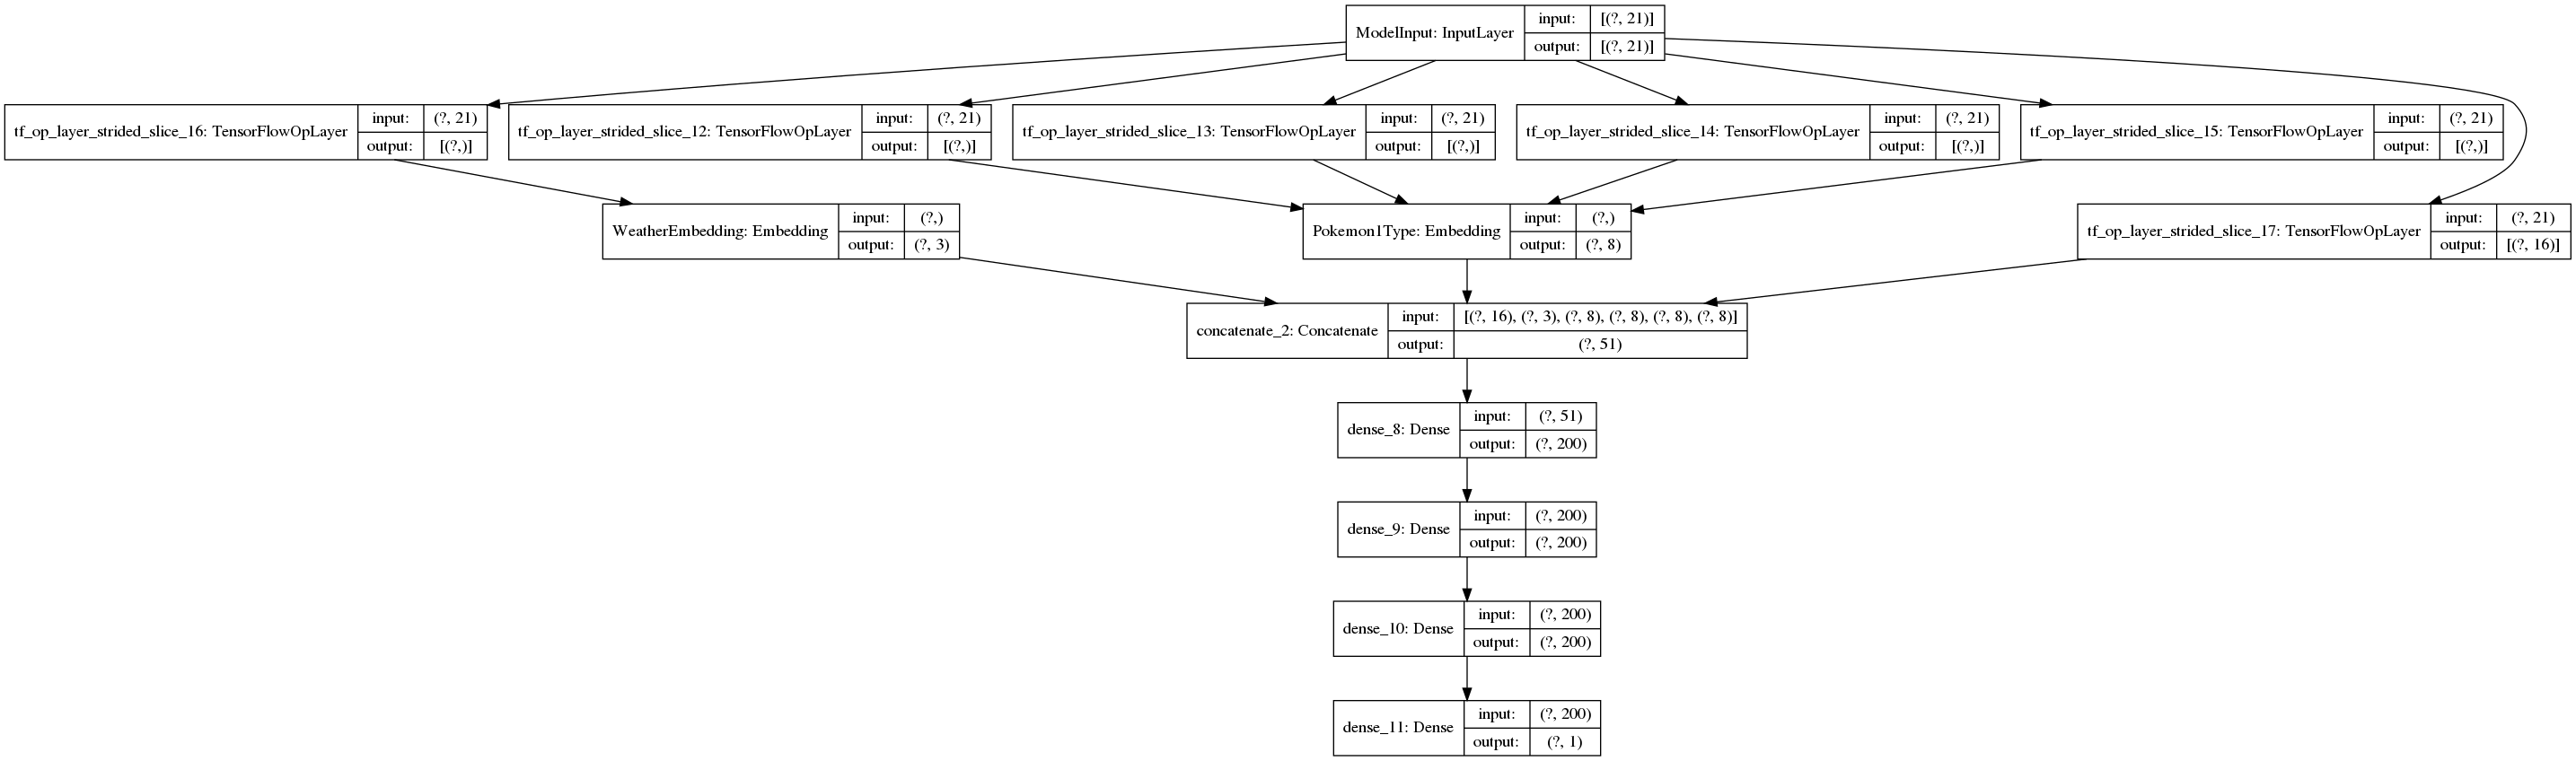

In [84]:
# Functional Model Architecture
""" Input columns are as follows:
- input[0:16] are numerical attributes
- input[16] is Ordinal WeatherAndTime
- input[17] is Ordinal Pokemon_1 First Nature
- input[18] is Ordinal Pokemon_1 Second Nature
- input[19] is Ordinal Pokemon_2 First Nature
- input[20] is Ordinal Pokemon_2 Second Nature
"""
model_input = layers.Input(shape=(21,), name='ModelInput')
type_emb = layers.Embedding(input_dim=18, output_dim=8, name="Pokemon1Type")
type1_emb_1 = type_emb(model_input[:,17])
type2_emb_1 = type_emb(model_input[:,18])
type1_emb_2 = type_emb(model_input[:,19])
type2_emb_2 = type_emb(model_input[:,20])
weather_emb = layers.Embedding(input_dim=5, output_dim=3, name="WeatherEmbedding")(model_input[:, 16])
x = layers.Concatenate()([model_input[:, 0:16], weather_emb, type1_emb_1, type2_emb_1, type1_emb_2, type2_emb_2])
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
model_output = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=model_input, outputs=model_output)
plot_model(model, show_shapes=True)

In [85]:
model.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(learning_rate=3e-3),
              metrics=['RootMeanSquaredError'])

### Train

In [86]:
history = model.fit(x_train_augm, y_train_augm, epochs=1,
                    validation_data=(x_val, y_val),
                    batch_size=1024)

4249/4249 [==============================] - 24s 6ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042


### Load/Save Model

In [90]:
savemodel = False
loadmodel = True
if (savemodel): model.save(data_path+'02_models/nn_model', overwrite=False)
if (loadmodel): model = keras.models.load_model(data_path+'02_models/nn_model')

### Generate Output

In [91]:
def create_inference_data():
    """Return Same Format as Battle Results with additional PokemonID column"""
    # Repeat every row 6 times
    merged = pd.DataFrame(np.repeat(AvailablePokemons.values,6,axis=0), columns=AvailablePokemons.columns)
    # Drop PokemonID from Submission
    Submission_dropped = Submission.drop(columns=['SelectedPokemonID'])
    # Concat with Submission
    merged = merged.apply(lambda row: pd.concat([row, Submission_dropped.iloc[row.name%6]]), axis=1)
    return merged

def export(predictions):
    predictions = predictions.reshape(-1)
    table = np.empty((len(AvailablePokemons), 7))
    for i in range(len(AvailablePokemons)):
        table[i, 0] = i+1
        table[i, 1:] = predictions[i*6: (i+1)*6]
    df = pd.DataFrame(data=table, columns=['SelectedPokemonID']+list(Submission.Name_2.values))
    return df.astype({'SelectedPokemonID': int})

In [92]:
inference_data = create_inference_data()

In [94]:
x_inference = full_pipeline.transform(inference_data)
inference_predictions = model.predict(x_inference)
output = export(inference_predictions)
output.to_csv(path_or_buf=data_path+'03_model_output/nn_model/inference.csv')

/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### Test over TestSet

In [95]:
model.evaluate(test_x, test_y)

8498/8498 [==============================] - 7s 872us/step - loss: 0.0058 - root_mean_squared_error: 0.0759


[0.005753282457590103, 0.07585039734840393]